In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data paths
train_data_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/train'
val_data_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/val'
test_data_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/test'

# Define image data generators with data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)


Found 6443 images belonging to 17 classes.
Found 413 images belonging to 17 classes.
Found 379 images belonging to 17 classes.


In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Sample images from the training set:


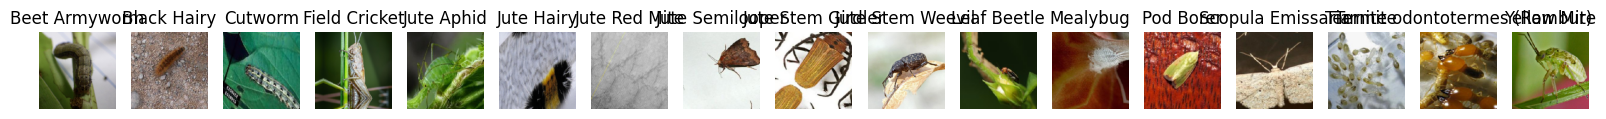

Sample images from the validation set:


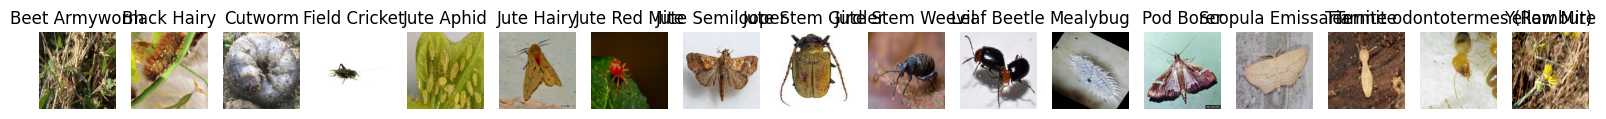

Sample images from the test set:


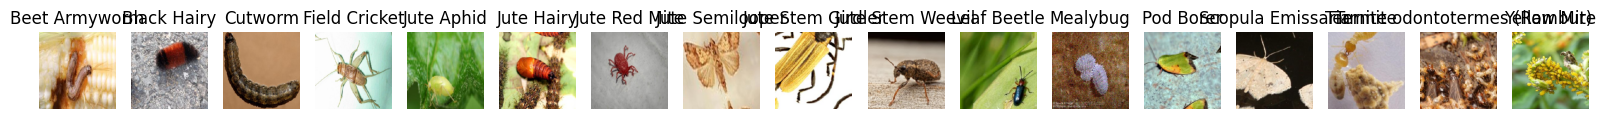

In [6]:

# Function to display one image per class from a given directory
def display_sample_images_from_directory(directory, img_size=(224, 224)):
    classes = sorted(os.listdir(directory))
    num_classes = len(classes)

    # Create a figure with subplots
    plt.figure(figsize=(20, num_classes))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        image_files = os.listdir(class_dir)
        if image_files:
            # Load one image from the class directory
            img_path = os.path.join(class_dir, image_files[0])
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0

            # Plot the image
            plt.subplot(1, num_classes, i + 1)
            plt.imshow(img_array)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Define data paths
train_data_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/train'
val_data_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/val'
test_data_dir = '/kaggle/input/jute-pest/Jute_Pest_Dataset/test'

# Display one image from each class in the training set
print("Sample images from the training set:")
display_sample_images_from_directory(train_data_dir)

# Display one image from each class in the validation set
print("Sample images from the validation set:")
display_sample_images_from_directory(val_data_dir)

# Display one image from each class in the test set
print("Sample images from the test set:")
display_sample_images_from_directory(test_data_dir)


In [7]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(17, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
import tensorflow as tf
# Define callbacks (optional)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Adjust based on your requirement
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726812790.048179     130 service.cc:145] XLA service 0x7de2b4005ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726812790.048233     130 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726812790.048238     130 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/201 ━━━━━━━━━━━━━━━━━━━━ 2:38:39 48s/step - accuracy: 0.0625 - loss: 3.0313

I0000 00:00:1726812812.623364     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 ━━━━━━━━━━━━━━━━━━━━ 182s 671ms/step - accuracy: 0.6670 - loss: 1.1124 - val_accuracy: 0.8750 - val_loss: 0.4421
Epoch 2/10
  1/201 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step - accuracy: 0.8438 - loss: 0.6272

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.8438 - loss: 0.6272 - val_accuracy: 0.9310 - val_loss: 0.1553
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 89s 429ms/step - accuracy: 0.9478 - loss: 0.1789 - val_accuracy: 0.9062 - val_loss: 0.4505
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.9688 - loss: 0.0896 - val_accuracy: 0.8621 - val_loss: 0.4658
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 90s 433ms/step - accuracy: 0.9479 - loss: 0.1571 - val_accuracy: 0.8984 - val_loss: 0.4925
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.8750 - loss: 0.3522 - val_accuracy: 0.8966 - val_loss: 0.4465
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 90s 433ms/step - accuracy: 0.9665 - loss: 0.1062 - val_accuracy: 0.8958 - val_loss: 0.5106


In [10]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('/kaggle/working/best_model.keras')

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9480 - loss: 0.1943 
Test Accuracy: 0.9419525265693665


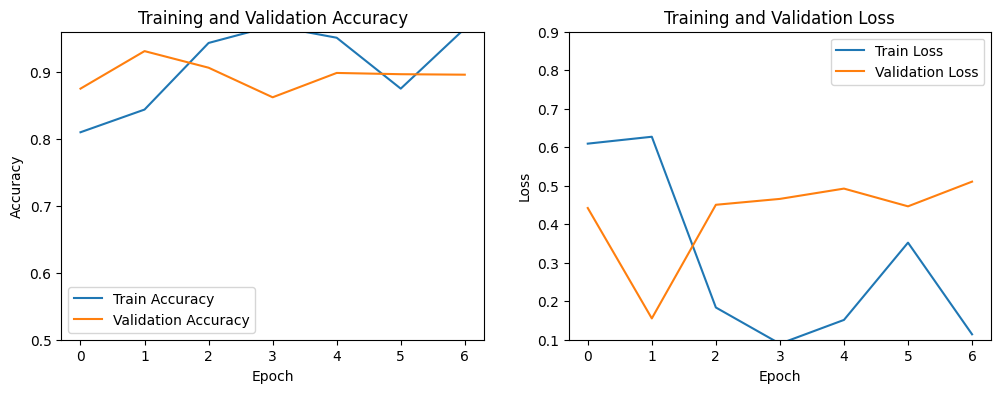

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.50, 0.96) 
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0.1, 0.9) 
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)


In [14]:
class_names = [
    "Beet Armyworm", "Black Hairy", "Cutworm", "Field Cricket", "Jute Aphid",
    "Jute Hairy", "Jute Red Mite", "Jute Semilooper", "Jute Stem Girdler",
    "Jute Stem Weevil", "Leaf Beetle", "Mealybug", "Pod Borer", "Scopula Emissaria",
    "Termite", "Termite odontotermes (Rambur)", "Yellow Mite"
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


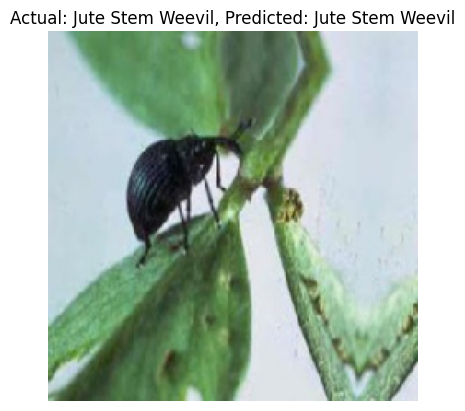

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


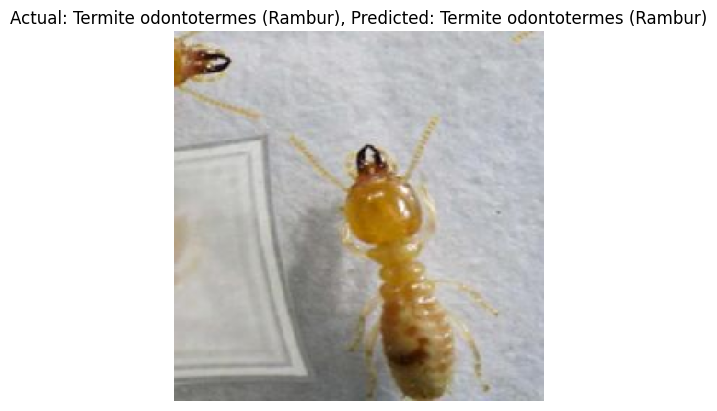

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


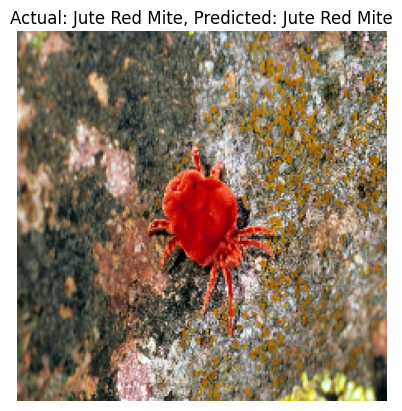

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


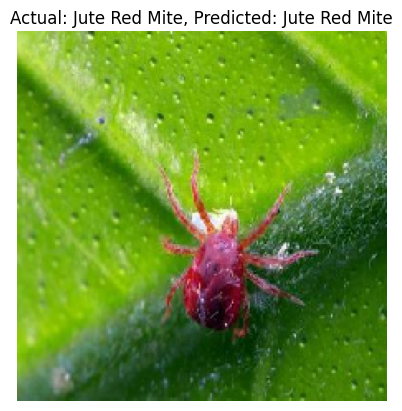

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


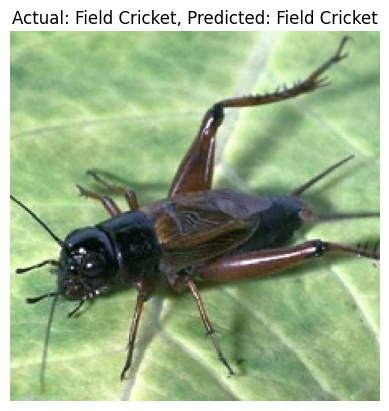

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to plot image with actual and predicted labels
def plot_image_with_label(image, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f'Actual: {actual_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Get 5 random images and their labels from the dataset
def check_random_images(generator, model, num_images=5):
    # Get the batch of images and labels from the generator
    images, labels = next(generator)
    
    # Randomly choose 5 images from the batch
    indices = random.sample(range(len(images)), num_images)
    
    for i in indices:
        image = images[i]
        actual_label_index = np.argmax(labels[i])
        actual_label = class_names[actual_label_index]  # Use the class name list
        
        # Make a prediction
        image_expanded = np.expand_dims(image, axis=0)  # Add batch dimension
        predicted_probabilities = model.predict(image_expanded)
        predicted_label_index = np.argmax(predicted_probabilities)
        predicted_label = class_names[predicted_label_index]  # Use the class name list
        
        # Plot image with labels
        plot_image_with_label(image, actual_label, predicted_label)

# Check the model on 5 random images from the validation set
check_random_images(val_generator, best_model)


In [16]:
from sklearn.metrics import classification_report


In [17]:
def get_classification_report(generator, model):
    # Get all predictions and true labels
    all_true_labels = []
    all_predictions = []
    
    for _ in range(len(generator)):
        images, labels = next(generator)
        predictions = model.predict(images)
        
        # Get the index of the class with the highest probability
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)
        
        all_true_labels.extend(true_classes)
        all_predictions.extend(predicted_classes)

    # Generate the classification report
    report = classification_report(all_true_labels, all_predictions, target_names=class_names)
    print(report)

# Generate and print the classification report for the validation set
get_classification_report(val_generator, best_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
                               precision    recall  f1-score   support

                Beet Armyworm       0.87      0.87      0.87        39
                  Black Hairy       0.88      1.00      0.94        30
                      Cutworm       0.93      0.82      0.87        17
                Field Cricket       0.92      1.00      0.96        12
                   Jute Aphid       0.71      0.93      0.81        27
                   Jute Hairy       0.90      0.90      0.90        10
          

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


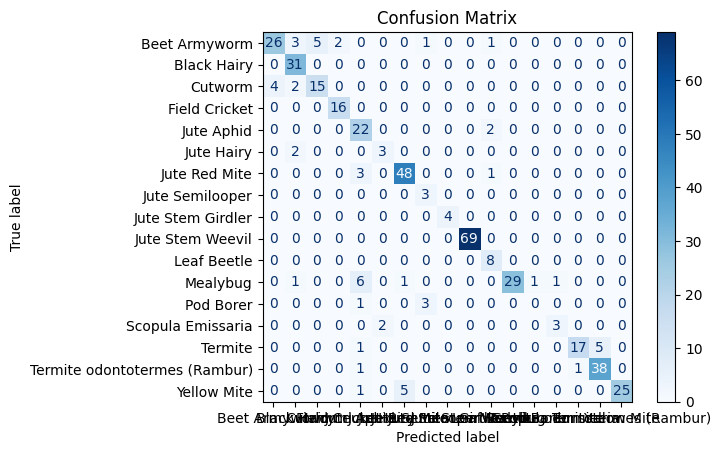

In [19]:
def plot_confusion_matrix(generator, model):
    # Get all true labels and predictions
    all_true_labels = []
    all_predictions = []
    
    for _ in range(len(generator)):
        images, labels = next(generator)
        predictions = model.predict(images)
        
        # Get the index of the class with the highest probability
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)
        
        all_true_labels.extend(true_classes)
        all_predictions.extend(predicted_classes)

    # Calculate the confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix for the validation set
plot_confusion_matrix(val_generator, best_model)
